In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", interp_length=None, transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.interp_length = interp_length
        self.filter = filter

    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        # Process ADC channels.
        if self.interp_length is not None:
            audio_arr = self._interpolate_channel(audio_arr, self.interp_length)
            adc1_arr = self._interpolate_channel(adc1_arr, self.interp_length)
            adc2_arr = self._interpolate_channel(adc2_arr, self.interp_length)
        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            torch.from_numpy(audio_arr.copy()),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def _interpolate_channel(self, arr, target_length):
        """
        Remove np.inf values from the array and linearly interpolate
        to the target_length.
        """
        # Remove padded inf values.
        valid = arr[~np.isinf(arr)]
        if len(valid) == 0:
            # If there is no valid data, return an array of zeros.
            return np.zeros(target_length, dtype=arr.dtype)
        # Generate new indices for interpolation.
        old_indices = np.arange(len(valid))
        new_indices = np.linspace(0, len(valid) - 1, target_length)
        return np.interp(new_indices, old_indices, valid)[:target_length]

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        return filtered_data

input_length = 300
# Path to the descriptor JSON file.
descriptor_path = 'descriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
dataset = MemmapDataset(descriptor_path, padding_handling="remove", interp_length=input_length, filter=True)
output_length = dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = dataset[1]
print("\nWith ADC interpolation to length 300:")
print("ADC1 shape:", sample[2].shape)
print("ADC2 shape:", sample[3].shape)

# Demonstrate accessing a descriptor field.
print("Audio Sampling Rate:", dataset.get("audio_sampling_rate"))
print("ADC Highcut:", dataset.get("adc_highcut"))


Number of classes: 37

With ADC interpolation to length 300:
ADC1 shape: torch.Size([300])
ADC2 shape: torch.Size([300])
Audio Sampling Rate: 48000
ADC Highcut: 3700


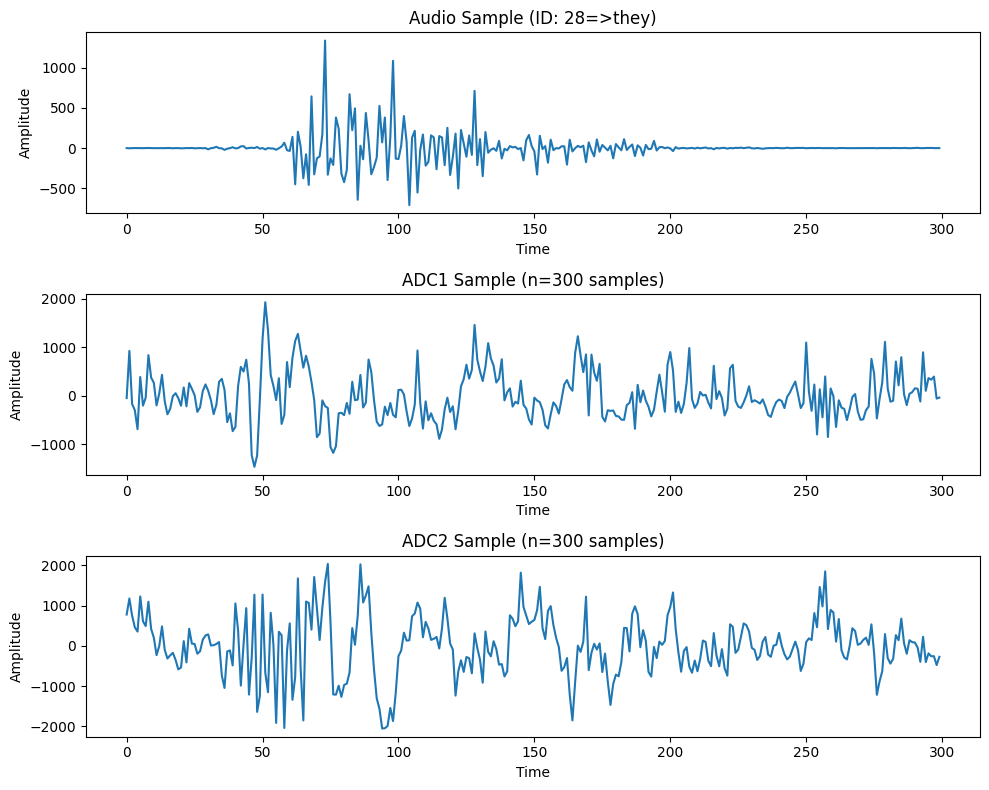

In [2]:
import matplotlib.pyplot as plt


rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

sample_id, audio, adc1, adc2 = sample  # unpack the tuple

# Convert tensors to numpy arrays for plotting
audio_np = audio.numpy()
adc1_np = adc1.numpy()
adc2_np = adc2.numpy()

# Create a figure with three subplots for audio, ADC1, and ADC2.
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

axs[0].plot(audio_np)
axs[0].set_title(f"Audio Sample (ID: {sample_id}=>{dataset.id_to_dataset(sample_id)})")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].plot(adc1_np)
axs[1].set_title(f"ADC1 Sample (n={len(adc1_np)} samples)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

axs[2].plot(adc2_np)
axs[2].set_title(f"ADC2 Sample (n={len(adc2_np)} samples)")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [3]:
# from torchprofile import profile_macs

import torch.nn as nn
import torch.nn.functional as F

# the data shape is (batch_size, 2, input_length)
# where 2 is the number of ADC channels and input_length is the length of each ADC channel.
# the output shape is (batch_size, output_length) where output_length is the number of classes.

# def computeModelStats(model, input_shape):
#     dummy_input = torch.randn(input_shape)
#     macs = profile_macs(model, dummy_input)
#     params = sum(p.numel() for p in model.parameters())
#     model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
#     print(f"MACs: {macs}")
#     print(f"Parameters: {params}")
#     print(f"Model Size: {model_size:.2f} MB")

def computeModelSize(model):
    params = sum(p.numel() for p in model.parameters())
    model_size = params * 4 / (1024 ** 2)  # Convert to MB assuming 32-bit (4 bytes) precision
    return model_size

class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, input_length, output_length):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv1d(2, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 2)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.layer4 = self._make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(512, output_length)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Test the model with dummy data
dummy = torch.randn(4, 2, input_length)
model = ResNet(input_length, output_length)
output = model(dummy)
print("Output shape is:", output.shape)
print(model)

# Compute model stats
# computeModelStats(model, (1, 2, input_length))
print(f"Model Size: {computeModelSize(model):.2f} MB")

Output shape is: torch.Size([4, 37])
ResNet(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResNetBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [4]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epoch(
    model,
    dataloader,
    epochs,
    learning_rate,
    optimizer=None,
    loss_function=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    model.train()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Training Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0
        
        for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
            audio = audio.to(device)
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(adc)
            loss = loss_function(outputs, ids)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            num_batches += 1
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == ids).sum().item()
            total += ids.size(0)
            
            if verbose > 0 and (batch_idx % log_interval == 0):
                msg = f"[TRAIN] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                if verbose == 1:
                    print(msg)
                if logger is not None and verbose != 0:
                    logger.log({"split": "train", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TRAIN] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "train", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})

    return epoch_results


def test_epoch(
    model,
    dataloader,
    epochs=1,
    loss_function=None,
    device='cpu',
    verbose=0,
    log_interval=100,
    logger=None,
):
    if loss_function is None:
        loss_function = nn.CrossEntropyLoss()

    model.to(device)
    model.eval()

    epoch_results = []

    for epoch in tqdm(range(epochs), desc="Testing Epochs", disable=(verbose == 0)):
        total_loss = 0.0
        correct = 0
        total = 0
        num_batches = 0

        with torch.no_grad():
            for batch_idx, (ids, audio, adc1, adc2) in enumerate(dataloader):
                ids = ids.to(device)
                adc1 = adc1.to(device)
                adc2 = adc2.to(device)
                
                adc = torch.stack((adc1, adc2), dim=1)
                outputs = model(adc)
                loss = loss_function(outputs, ids)
                
                total_loss += loss.item()
                num_batches += 1
                
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == ids).sum().item()
                total += ids.size(0)
                
                if verbose > 0 and (batch_idx % log_interval == 0):
                    msg = f"[TEST] Epoch: {epoch}/{epochs}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {100 * correct / total:.2f}%"
                    if verbose == 1:
                        print(msg)
                    if logger is not None and verbose != 0:
                        logger.log({"split": "test", "epoch": epoch, "batch_idx": batch_idx, "loss": loss.item(), "accuracy": 100 * correct / total})

        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100 * correct / total
        epoch_results.append((avg_loss, accuracy))
        if verbose == 1:
            print(f"[TEST] End of Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
        if logger is not None and verbose != 0:
            logger.log({"split": "test", "epoch": epoch, "avg_loss": avg_loss, "accuracy": accuracy})

    return epoch_results


In [5]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.8
val_ratio = 0.2

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader instances for training and validation sets
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, audio, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, audio, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("Audio shape:", audio.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([10,  7, 27,  7])
Audio shape: torch.Size([4, 300])
ADC1 shape: torch.Size([4, 300])
ADC2 shape: torch.Size([4, 300])
Batch 2:
IDs: tensor([26, 17,  3, 30])
Audio shape: torch.Size([4, 300])
ADC1 shape: torch.Size([4, 300])
ADC2 shape: torch.Size([4, 300])
Batch 1:
IDs: tensor([15, 11, 34, 23])
Audio shape: torch.Size([4, 300])
ADC1 shape: torch.Size([4, 300])
ADC2 shape: torch.Size([4, 300])
Batch 2:
IDs: tensor([28, 30, 34, 19])
Audio shape: torch.Size([4, 300])
ADC1 shape: torch.Size([4, 300])
ADC2 shape: torch.Size([4, 300])
Number of training samples: 880
Number of validation samples: 220


In [6]:
# !wandb login

In [7]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [8]:
TOTAL_EPOCHS = 10
PER_EPOCH = 2

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
verbosity = 1

In [9]:
# the actual trainign loop
train_stats = []
test_stats = []
for epoch in range(TOTAL_EPOCHS):
    res =train_epoch(model, train_loader, epochs=PER_EPOCH, learning_rate=0.001, device=global_device, verbose=1)
    train_stats.extend(res)
    res = test_epoch(model, val_loader, epochs=1, device=global_device, verbose=1)
    test_stats.extend(res)



Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 3.4314, Accuracy: 0.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 4.1904, Accuracy: 5.45%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 3.2466, Accuracy: 9.83%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.07s/it]

[TRAIN] End of Epoch 0, Avg Loss: 3.4467, Accuracy: 10.11%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 2.6678, Accuracy: 25.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 2.7027, Accuracy: 13.12%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 2.1758, Accuracy: 14.93%


Training Epochs: 100%|██████████| 2/2 [00:14<00:00,  7.07s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.9556, Accuracy: 15.00%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 2.8883, Accuracy: 0.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.92it/s]


[TEST] End of Epoch 0, Avg Loss: 2.7098, Accuracy: 18.18%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 2.2004, Accuracy: 50.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 3.7627, Accuracy: 14.85%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 2.8021, Accuracy: 17.04%


Training Epochs:  50%|█████     | 1/2 [00:06<00:06,  6.09s/it]

[TRAIN] End of Epoch 0, Avg Loss: 2.8971, Accuracy: 17.05%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 2.1430, Accuracy: 25.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 2.0684, Accuracy: 23.27%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 1.6466, Accuracy: 23.38%


Training Epochs: 100%|██████████| 2/2 [00:12<00:00,  6.13s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.5031, Accuracy: 23.75%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 1.1526, Accuracy: 75.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


[TEST] End of Epoch 0, Avg Loss: 1.9706, Accuracy: 41.82%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 2.2267, Accuracy: 50.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 1.8840, Accuracy: 29.70%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 2.4906, Accuracy: 32.34%


Training Epochs:  50%|█████     | 1/2 [00:06<00:06,  6.41s/it]

[TRAIN] End of Epoch 0, Avg Loss: 2.2498, Accuracy: 32.27%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 3.6188, Accuracy: 25.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 3.4555, Accuracy: 34.90%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 2.2620, Accuracy: 36.94%


Training Epochs: 100%|██████████| 2/2 [00:13<00:00,  6.65s/it]


[TRAIN] End of Epoch 1, Avg Loss: 2.0217, Accuracy: 36.14%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 1.9886, Accuracy: 25.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s]


[TEST] End of Epoch 0, Avg Loss: 1.6511, Accuracy: 45.91%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 1.8551, Accuracy: 25.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 2.2153, Accuracy: 48.02%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 0.6541, Accuracy: 46.52%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.62s/it]

[TRAIN] End of Epoch 0, Avg Loss: 1.7794, Accuracy: 47.27%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 2.6810, Accuracy: 0.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 1.1833, Accuracy: 52.97%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 1.0421, Accuracy: 51.62%


Training Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.53s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.5570, Accuracy: 51.36%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 1.5527, Accuracy: 25.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


[TEST] End of Epoch 0, Avg Loss: 1.5683, Accuracy: 48.64%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 0.2662, Accuracy: 100.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 0.4918, Accuracy: 52.72%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 1.1407, Accuracy: 54.85%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.75s/it]

[TRAIN] End of Epoch 0, Avg Loss: 1.4745, Accuracy: 54.77%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 0.7984, Accuracy: 50.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 1.2736, Accuracy: 64.36%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 0.7338, Accuracy: 65.30%


Training Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.72s/it]


[TRAIN] End of Epoch 1, Avg Loss: 1.1483, Accuracy: 65.68%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 0.9160, Accuracy: 75.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


[TEST] End of Epoch 0, Avg Loss: 1.1975, Accuracy: 61.36%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 1.8826, Accuracy: 50.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 0.6057, Accuracy: 65.10%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 3.2115, Accuracy: 65.30%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.46s/it]

[TRAIN] End of Epoch 0, Avg Loss: 1.1185, Accuracy: 65.11%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 1.3872, Accuracy: 50.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 0.7407, Accuracy: 69.55%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 1.8553, Accuracy: 67.79%


Training Epochs: 100%|██████████| 2/2 [00:14<00:00,  7.49s/it]


[TRAIN] End of Epoch 1, Avg Loss: 0.9881, Accuracy: 67.73%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 2.2799, Accuracy: 50.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


[TEST] End of Epoch 0, Avg Loss: 1.0332, Accuracy: 67.73%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 0.8961, Accuracy: 75.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 1.2609, Accuracy: 73.76%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 1.7514, Accuracy: 73.76%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.43s/it]

[TRAIN] End of Epoch 0, Avg Loss: 0.8548, Accuracy: 73.41%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 0.7318, Accuracy: 75.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 0.2739, Accuracy: 75.74%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 0.8308, Accuracy: 77.86%


Training Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.79s/it]


[TRAIN] End of Epoch 1, Avg Loss: 0.7173, Accuracy: 77.84%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 1.0033, Accuracy: 75.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]


[TEST] End of Epoch 0, Avg Loss: 0.9028, Accuracy: 71.36%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 0.4129, Accuracy: 75.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 0.1133, Accuracy: 80.20%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 1.1049, Accuracy: 80.10%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.79s/it]

[TRAIN] End of Epoch 0, Avg Loss: 0.6210, Accuracy: 80.23%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 0.9241, Accuracy: 75.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 0.0961, Accuracy: 83.91%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 0.0756, Accuracy: 83.46%


Training Epochs: 100%|██████████| 2/2 [00:15<00:00,  7.77s/it]


[TRAIN] End of Epoch 1, Avg Loss: 0.5570, Accuracy: 83.30%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 0.7400, Accuracy: 75.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


[TEST] End of Epoch 0, Avg Loss: 0.7557, Accuracy: 78.64%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 0.4206, Accuracy: 100.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 0.1419, Accuracy: 84.65%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 0.6043, Accuracy: 84.70%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.28s/it]

[TRAIN] End of Epoch 0, Avg Loss: 0.5040, Accuracy: 84.66%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 0.0212, Accuracy: 100.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 0.4615, Accuracy: 87.13%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 0.1184, Accuracy: 86.32%


Training Epochs: 100%|██████████| 2/2 [00:14<00:00,  7.43s/it]


[TRAIN] End of Epoch 1, Avg Loss: 0.4434, Accuracy: 86.93%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 0.4507, Accuracy: 75.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


[TEST] End of Epoch 0, Avg Loss: 0.9569, Accuracy: 72.73%


Training Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

[TRAIN] Epoch: 0/2, Batch: 0, Loss: 0.0588, Accuracy: 100.00%
[TRAIN] Epoch: 0/2, Batch: 100, Loss: 0.0818, Accuracy: 87.87%
[TRAIN] Epoch: 0/2, Batch: 200, Loss: 0.3803, Accuracy: 86.94%


Training Epochs:  50%|█████     | 1/2 [00:07<00:07,  7.42s/it]

[TRAIN] End of Epoch 0, Avg Loss: 0.4349, Accuracy: 85.57%
[TRAIN] Epoch: 1/2, Batch: 0, Loss: 0.0290, Accuracy: 100.00%
[TRAIN] Epoch: 1/2, Batch: 100, Loss: 0.0856, Accuracy: 91.34%
[TRAIN] Epoch: 1/2, Batch: 200, Loss: 0.0995, Accuracy: 90.30%


Training Epochs: 100%|██████████| 2/2 [00:14<00:00,  7.27s/it]


[TRAIN] End of Epoch 1, Avg Loss: 0.3478, Accuracy: 90.45%


Testing Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

[TEST] Epoch: 0/1, Batch: 0, Loss: 0.3410, Accuracy: 100.00%


Testing Epochs: 100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

[TEST] End of Epoch 0, Avg Loss: 0.9273, Accuracy: 73.18%


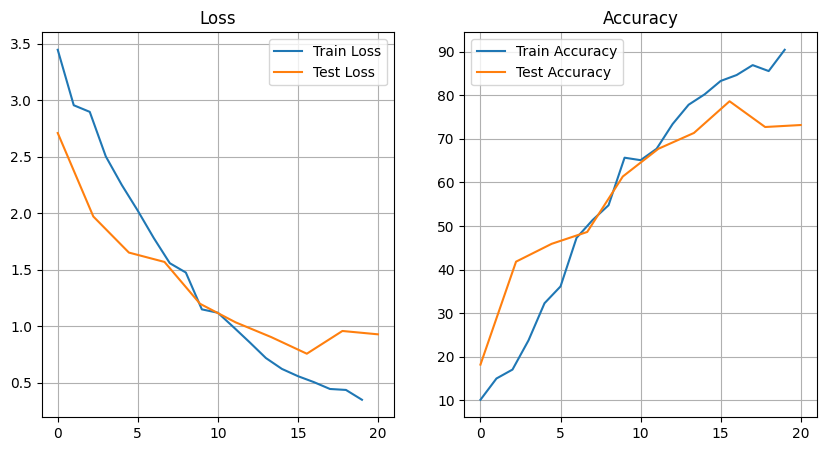

In [10]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc = [stat[1] for stat in train_stats]
test_loss = [stat[0] for stat in test_stats]
test_acc = [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()

100%|██████████| 55/55 [00:00<00:00, 99.96it/s] 


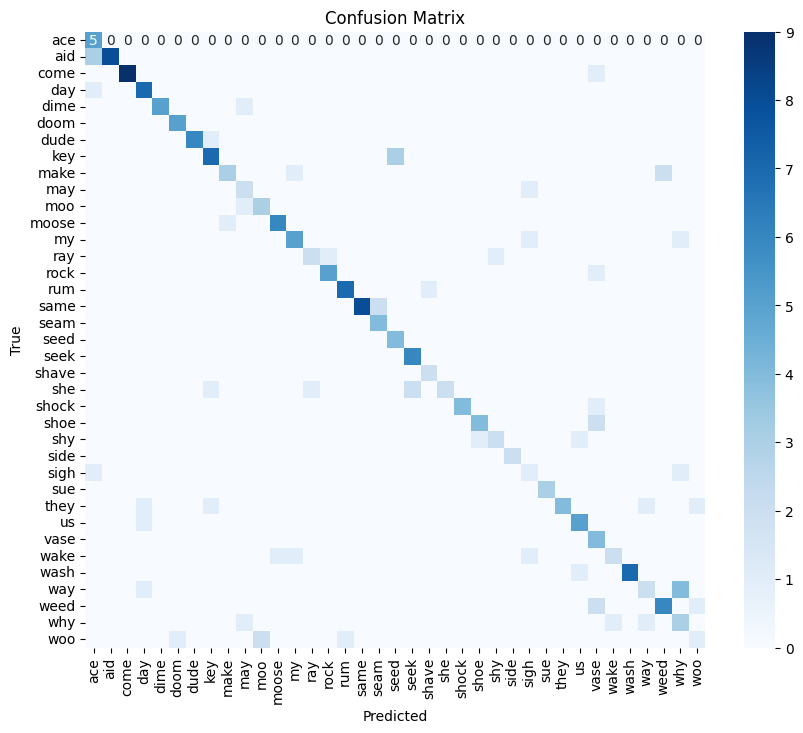

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Function to evaluate the model and generate the confusion matrix
def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for ids, audio, adc1, adc2 in tqdm(dataloader):
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids = ids.to(device)
            
            adc = torch.stack((adc1, adc2), dim=1)
            outputs = model(adc)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(ids.cpu().numpy())
    
    return all_labels, all_preds

# Evaluate the model on the validation set
labels, preds = evaluate_model(model, val_loader, device=global_device)

# Generate the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Replace IDs with dataset names
label_names = [dataset.id_to_dataset(label) for label in range(output_length)]
pred_names = [dataset.id_to_dataset(pred) for pred in range(output_length)]

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=pred_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()